# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer, InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
pip install split-folders

'HAM_CCNN'

In [ ]:
import splitfolders
splitfolders.ratio("images", output="./", seed=1337, ratio=(.70, .15, 0.15), group_prefix=None) # default values

In [3]:
train_path = 'HAM_CCNN/train_dir'
test_path = 'HAM_CCNN/test_dir'
val_path = 'HAM_CCNN/val_dir'

In [4]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
num_classes = 7
image_size = 224
batch_size = 16

# Train Set Augmentation

In [5]:
# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    if not os.path.exists(aug_dir):
        os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    img_list = os.listdir(train_path + '/' + img_class)

    # Copy images from the class train dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join(train_path + '/' + img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = train_path + '/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(image_size, image_size),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000 

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree('aug_dir')

Found 282 images belonging to 1 classes.
Found 461 images belonging to 1 classes.
Found 967 images belonging to 1 classes.
Found 103 images belonging to 1 classes.
Found 1044 images belonging to 1 classes.
Found 5380 images belonging to 1 classes.
Found 123 images belonging to 1 classes.


## Dataset generation (Train, Test, Validation)

In [6]:
# Creating Image Data Generator for train
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0
    )

# Creating Image Data Generator for test set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0
    )

# Creating Image Data Generator for val set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0
    )

In [7]:
print("\nTrain Batches: ")
train_batches = train_datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = test_datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = val_datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 54782 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.

Val Batches: 
Found 827 images belonging to 7 classes.


# Main Model Creation

## custom model creation

In [ ]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [8]:
MainInput=Input(shape=(image_size, image_size, 3))

In [9]:
conv=(Conv2D(filters=64,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(MainInput))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=64,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=64,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)

In [10]:
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))

In [11]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)

In [12]:
conv=(MaxPooling2D()(conv))

In [13]:
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)

In [14]:
conv=(MaxPooling2D()(conv))

In [15]:
conv=(Conv2D(filters=512,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=512,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)

In [16]:
conv=(MaxPooling2D()(conv))

In [17]:
conv=(Conv2D(filters=1024,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=1024,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=1024,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)

In [18]:
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

In [19]:
num_classes = train_batches.num_classes
print("Number of classes: ", num_classes)

Number of classes:  7


In [ ]:
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dropout(0.5)(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dropout(0.4)(conv))
conv=(Dense(256,activation="relu")(conv))
conv=(Dropout(0.35)(conv))
conv=(Dense(128,activation="relu")(conv))
conv=(Dropout(0.25)(conv))
conv=(Dense(num_classes, activation="softmax")(conv))
# if your data is binary class, use activation="sigmoid" instead of activation="softmax" in the last line only.

## Model (Custom CNN)

In [21]:
model_cacnn = Model(inputs=MainInput, outputs=conv)

In [22]:
model_cacnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      4160      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0     

In [23]:
opt1 = tf.keras.optimizers.Adam(learning_rate = 0.001,epsilon = 0.1)
model_cacnn.compile(optimizer = opt1,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [25]:
checkpoint1 = ModelCheckpoint(filepath = 'CusMd.hdf5', monitor = 'val_accuracy', save_best_only = True, save_weights_only = True)
Earlystop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 25, min_delta = 0.001)

In [26]:
history_cacnn = model_cacnn.fit(train_batches,
                              epochs = 50,
                              verbose = 2,
                              validation_data = val_batches,
                              callbacks = [checkpoint1,Earlystop])

Epoch 1/150
3424/3424 - 479s - loss: 3.2063 - accuracy: 0.2457 - val_loss: 1.7949 - val_accuracy: 0.1088 - 479s/epoch - 140ms/step
Epoch 2/150
3424/3424 - 460s - loss: 2.5696 - accuracy: 0.3967 - val_loss: 1.4423 - val_accuracy: 0.4027 - 460s/epoch - 134ms/step
Epoch 3/150
3424/3424 - 460s - loss: 2.2680 - accuracy: 0.4929 - val_loss: 2.2750 - val_accuracy: 0.1560 - 460s/epoch - 134ms/step
Epoch 4/150
3424/3424 - 461s - loss: 2.0555 - accuracy: 0.5572 - val_loss: 1.2006 - val_accuracy: 0.5103 - 461s/epoch - 135ms/step
Epoch 5/150
3424/3424 - 462s - loss: 1.8713 - accuracy: 0.6069 - val_loss: 0.5414 - val_accuracy: 0.8126 - 462s/epoch - 135ms/step
Epoch 6/150
3424/3424 - 462s - loss: 1.7240 - accuracy: 0.6443 - val_loss: 0.5831 - val_accuracy: 0.7775 - 462s/epoch - 135ms/step
Epoch 7/150
3424/3424 - 462s - loss: 1.5838 - accuracy: 0.6754 - val_loss: 0.5499 - val_accuracy: 0.7751 - 462s/epoch - 135ms/step
Epoch 8/150
3424/3424 - 462s - loss: 1.4624 - accuracy: 0.7038 - val_loss: 0.7194 -

### Plotting accuracy and loss

In [27]:
# Determine number of epochs trained
num_epochs_trained = len(history_cacnn.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

Number of epochs trained: 40


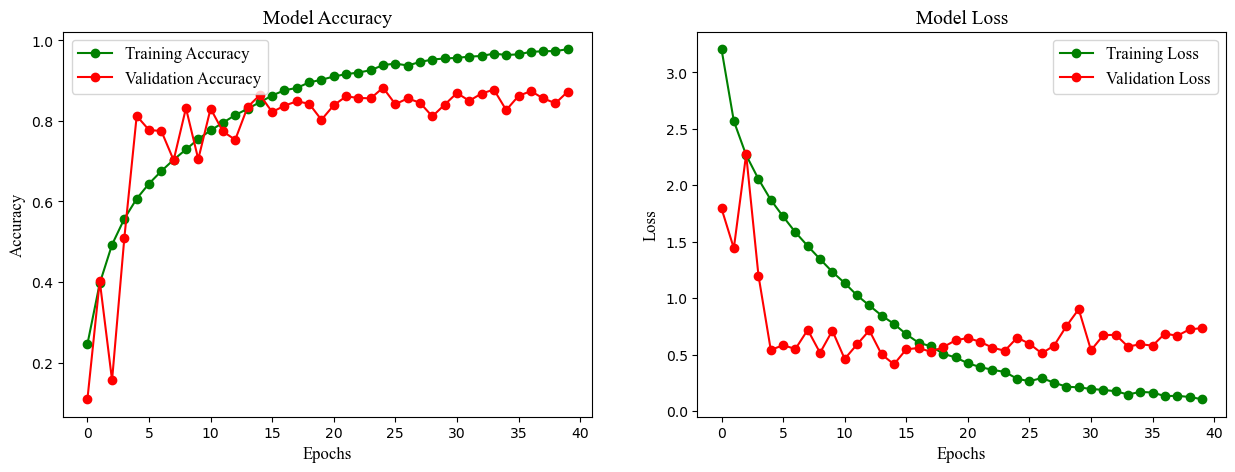

In [28]:
## History plotting

epochs = [i for i in range(num_epochs_trained)]
fig , ax = plt.subplots(1,2)
train_acc = history_cacnn.history['accuracy']
train_loss = history_cacnn.history['loss']
val_acc = history_cacnn.history['val_accuracy']
val_loss = history_cacnn.history['val_loss']
fig.set_size_inches(15,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
ax[0].set_title('Model Accuracy', fontdict=title_font)
legend_font = {'family': 'Times New Roman', 'size': '12', 'weight': 'normal'}
ax[0].legend(prop=legend_font)
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}
ax[0].set_xlabel("Epochs",  fontdict=label_font)
ax[0].set_ylabel("Accuracy",  fontdict=label_font)

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Model Loss', fontdict=title_font)
ax[1].legend(prop=legend_font)
ax[1].set_xlabel("Epochs", fontdict=label_font)
ax[1].set_ylabel("Loss", fontdict=label_font)
plt.show()

In [29]:
from tensorflow.keras import models
model_cacnn.load_weights("CusMd.hdf5")

In [30]:
predictions = model_cacnn.predict(test_batches)

52/52 [==============================] - 8s 154ms/step


In [31]:
## Creating classification report 

#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.75      0.41      0.53        22
         bcc       0.72      0.67      0.69        27
         bkl       0.65      0.59      0.62        66
          df       0.00      0.00      0.00         6
         mel       0.46      0.49      0.47        35
          nv       0.95      0.97      0.96       663
        vasc       0.42      0.56      0.48         9

    accuracy                           0.88       828
   macro avg       0.56      0.53      0.54       828
weighted avg       0.88      0.88      0.88       828



[[  9   3   5   1   1   3   0]
 [  2  18   3   0   4   0   0]
 [  0   1  39   0   9  17   0]
 [  0   1   1   0   1   3   0]
 [  1   0   4   0  17  12   1]
 [  0   0   8   1   5 643   6]
 [  0   2   0   1   0   1   5]]


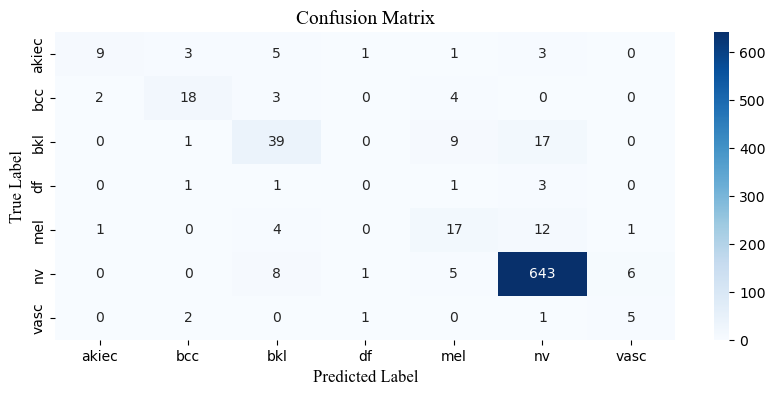

In [32]:
## Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
print(cm)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

## Results

In [33]:
### Individual Class Accuracy 

# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 88.29%
Accuracy for each class:
Class 0: 40.91%
Class 1: 66.67%
Class 2: 59.09%
Class 3: 0.00%
Class 4: 48.57%
Class 5: 96.98%
Class 6: 55.56%


In [34]:
### Individual Class Weighted Precision

report = classification_report(y_true, y_pred, output_dict=True)
# Extract weighted precision for each class
class_precision = {}
for class_label in report.keys():
    if class_label == 'weighted avg':
        class_precision['weighted'] = report[class_label]['precision']
    elif class_label.isdigit():
        class_precision[int(class_label)] = report[class_label]['precision']
print("Weighted precision for each class:")
for i, precision in class_precision.items():
    if i == 'weighted':
        print("Weighted precision: {:.2f}%".format(precision*100))
    else:
        print("Class {}: {:.2f}%".format(i, precision*100))

Weighted precision for each class:
Class 0: 75.00%
Class 1: 72.00%
Class 2: 65.00%
Class 3: 0.00%
Class 4: 45.95%
Class 5: 94.70%
Class 6: 41.67%
Weighted precision: 87.74%


In [35]:
### Individual Class Weighted Recall

report = classification_report(y_true, y_pred, output_dict=True)
# Extract weighted recall for each class
class_recall = {}
for class_label in report.keys():
    if class_label == 'weighted avg':
        class_recall['weighted'] = report[class_label]['recall']
    elif class_label.isdigit():
        class_recall[int(class_label)] = report[class_label]['recall']
print("Weighted recall for each class:")
for i, recall in class_recall.items():
    if i == 'weighted':
        print("Weighted Recall: {:.2f}%".format(recall*100))
    else:
        print("Class {}: {:.2f}%".format(i, recall*100))

Weighted recall for each class:
Class 0: 40.91%
Class 1: 66.67%
Class 2: 59.09%
Class 3: 0.00%
Class 4: 48.57%
Class 5: 96.98%
Class 6: 55.56%
Weighted Recall: 88.29%


In [36]:
### Individual Class Weighted F1-score

report = classification_report(y_true, y_pred, output_dict=True)
# Extract weighted F1-score for each class
class_f1 = {}
for class_label in report.keys():
    if class_label == 'weighted avg':
        class_f1['weighted'] = report[class_label]['f1-score']
    elif class_label.isdigit():
        class_f1[int(class_label)] = report[class_label]['f1-score']
print("Weighted F1-score for each class:")
for i, f1_score in class_f1.items():
    if i == 'weighted':
        print("Weighted F1-score: {:.2f}%".format(f1_score*100))
    else:
        print("Class {}: {:.2f}%".format(i, f1_score*100))

Weighted F1-score for each class:
Class 0: 52.94%
Class 1: 69.23%
Class 2: 61.90%
Class 3: 0.00%
Class 4: 47.22%
Class 5: 95.83%
Class 6: 47.62%
Weighted F1-score: 87.84%


In [37]:
### Individual Class Precision, Recall and F1-score

from sklearn.metrics import precision_recall_fscore_support

precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_true, y_pred, average=None)
print('Class-wise weighted precision, recall, and F1-score:')
for i in range(len(precision_class)):
    print('Class {}: Precision={:.2f}, Recall={:.2f}, F1-score={:.2f}'.format(i, precision_class[i], recall_class[i], f1_class[i]))


Class-wise weighted precision, recall, and F1-score:
Class 0: Precision=0.75, Recall=0.41, F1-score=0.53
Class 1: Precision=0.72, Recall=0.67, F1-score=0.69
Class 2: Precision=0.65, Recall=0.59, F1-score=0.62
Class 3: Precision=0.00, Recall=0.00, F1-score=0.00
Class 4: Precision=0.46, Recall=0.49, F1-score=0.47
Class 5: Precision=0.95, Recall=0.97, F1-score=0.96
Class 6: Precision=0.42, Recall=0.56, F1-score=0.48


In [38]:
### Individual Class Weighted Sensitivity

from imblearn.metrics import sensitivity_score

sensitivity = sensitivity_score(y_true, y_pred, average='weighted')
print("Weighted Sensitivity: ", sensitivity)

# Calculate class-wise sensitivity
sensitivity = sensitivity_score(y_true, y_pred, average=None)

# Print sensitivity score for each class
for i in range(len(sensitivity)):
    print("Class ", i, ":sensitivity =", sensitivity[i])

Weighted Sensitivity:  0.8828502415458938
Class  0 :sensitivity = 0.4090909090909091
Class  1 :sensitivity = 0.6666666666666666
Class  2 :sensitivity = 0.5909090909090909
Class  3 :sensitivity = 0.0
Class  4 :sensitivity = 0.4857142857142857
Class  5 :sensitivity = 0.9698340874811463
Class  6 :sensitivity = 0.5555555555555556


In [39]:
### Individual Class Weighted Specificity

from imblearn.metrics import specificity_score

specificity = specificity_score(y_true, y_pred, average='weighted')
print("Weighted Specificity: ", specificity)

# Calculate class-wise specificity
specificity = specificity_score(y_true, y_pred, average=None)

# Print sensitivity score for each class
for i in range(len(specificity)):
    print("Class ", i, ":specificity=", specificity[i])


Weighted Specificity:  0.821530400090235
Class  0 :specificity= 0.9962779156327544
Class  1 :specificity= 0.9912609238451935
Class  2 :specificity= 0.9724409448818898
Class  3 :specificity= 0.9963503649635036
Class  4 :specificity= 0.9747793190416141
Class  5 :specificity= 0.7818181818181819
Class  6 :specificity= 0.9914529914529915


In [40]:
### Accuracy

print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.8828502415458938


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)

In [41]:
from sklearn.metrics import f1_score


In [42]:
### Weighted Evaluation Measures

print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Sensitivity: "+ str(sensitivity_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))


Weighted Precision: 0.8774388736883134
Weighted Recall: 0.8828502415458938
Weighted F1-Score: 0.8784345791555483
Weighted Sensitivity: 0.8828502415458938
Weighted Specificity: 0.821530400090235
weighted Roc score: 0.9663866092321894


In [43]:
### Macro Evaluation Measures

print("Macro Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Macro Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Macro F1-Score: "+ str(f1_score(y_true, y_pred, average='macro')))
print("Macro Sensitivity: "+ str(sensitivity_score(y_true, y_pred, average='macro')))
print("Macro Specificity: "+ str(specificity_score(y_true, y_pred, average='macro')))
print("Macro Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='macro')))

Macro Precision: 0.5633009971890679
Macro Recall: 0.5253957993453792
Macro F1-Score: 0.535350144490522
Macro Sensitivity: 0.5253957993453792
Macro Specificity: 0.9577686630908755
Macro Roc score: 0.9508714860468034


In [44]:
### Micro Evaluation Measures

print("Micro Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Micro Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Micro F1-Score: "+ str(f1_score(y_true, y_pred, average='micro')))
print("Micro Sensitivity: "+ str(sensitivity_score(y_true, y_pred, average='micro')))
print("Micro Specificity: "+ str(specificity_score(y_true, y_pred, average='micro')))

Micro Precision: 0.8828502415458938
Micro Recall: 0.8828502415458938
Micro F1-Score: 0.8828502415458938
Micro Sensitivity: 0.8828502415458938
Micro Specificity: 0.980475040257649


### ROC

The ROC AUC score of akiec is: 0.9584367245657568
The ROC AUC score of bcc is: 0.9885790909511258
The ROC AUC score of bkl is: 0.9366300803308677
The ROC AUC score of df is: 0.9369424168694241
The ROC AUC score of mel is: 0.8949378490362097
The ROC AUC score of nv is: 0.9727272727272728
The ROC AUC score of vasc is: 0.9678469678469679


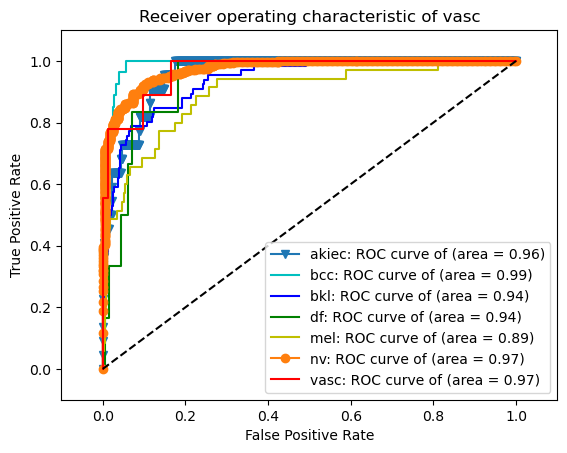

In [45]:
## ROC

### Individual Class Wise ROC AUC

fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

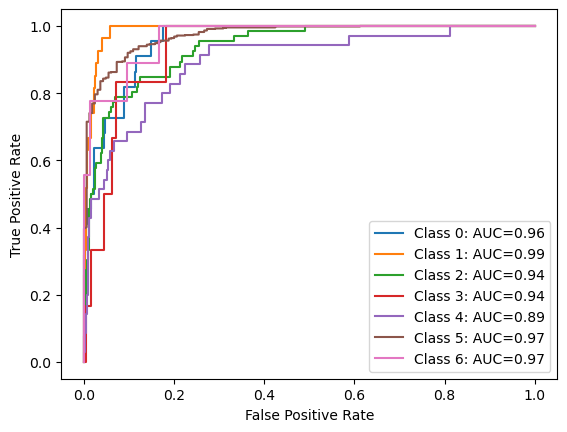

In [46]:
### Compute ROC curve and ROC area for each class

fpr = {}
tpr = {}
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(7):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.2f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [47]:
## MCC and Kappa Score

from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print("MCC: {:.2f}%".format(mcc*100))
print("Kappa Score: {:.2f}%".format(kappa*100))

MCC: 65.07%
Kappa Score: 64.94%


In [48]:
### Individual Class Wise MCC and Kappa

from sklearn.metrics import confusion_matrix, matthews_corrcoef, cohen_kappa_score
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
conf_mat = confusion_matrix(y_true, y_pred)
mcc_per_class = {}
kappa_per_class = {}

for i in range(len(conf_mat)):
    tp = conf_mat[i][i]
    fp = sum(conf_mat[:, i]) - tp
    fn = sum(conf_mat[i, :]) - tp
    tn = sum(sum(conf_mat)) - tp - fp - fn

    mcc_per_class[i] = matthews_corrcoef([1 if x==i else 0 for x in y_true], [1 if x==i else 0 for x in y_pred])
    kappa_per_class[i] = cohen_kappa_score([1 if x==i else 0 for x in y_true], [1 if x==i else 0 for x in y_pred])

print("MCC per class:")
for i, mcc in mcc_per_class.items():
    print("Class {}: {:.2f}%".format(i, mcc*100))

print("Kappa Score per class:")
for i, kappa in kappa_per_class.items():
    print("Class {}: {:.2f}%".format(i, kappa*100))

MCC per class:
Class 0: 54.55%
Class 1: 68.29%
Class 2: 58.85%
Class 3: -0.52%
Class 4: 44.84%
Class 5: 78.16%
Class 6: 47.46%
Kappa Score per class:
Class 0: 52.04%
Class 1: 68.23%
Class 2: 58.78%
Class 3: -0.49%
Class 4: 44.83%
Class 5: 78.01%
Class 6: 46.96%


## Grad CAM Visualization

In [49]:
last_conv_layer_name = None

for layer in reversed(model_cacnn.layers):
    if 'conv2d' in layer.name:
        last_conv_layer_name = layer.name
        break

print("Last Conv2D layer name:", last_conv_layer_name)


Last Conv2D layer name: conv2d_12


Found 828 images belonging to 7 classes.


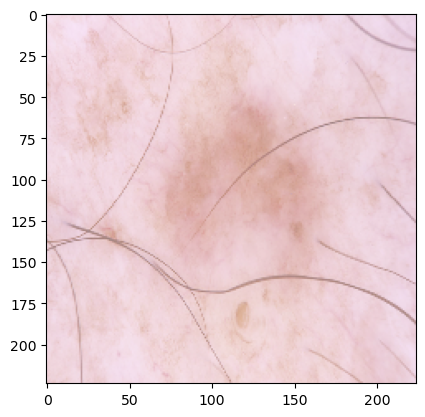

In [50]:
# Gradient Class Activation Map

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

test_batches = test_datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)

img_size = (image_size, image_size)
img_array,_=next(test_batches)
last_conv_layer_name = last_conv_layer_name
plt.imshow((img_array[0]+1)/2)

In [51]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 174ms/step


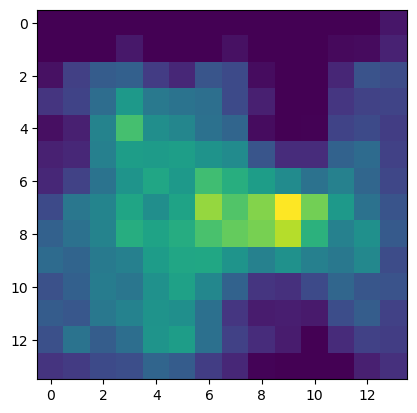

In [52]:
preds = model_cacnn.predict(img_array)
np.argmax(preds)
heatmap = make_gradcam_heatmap(img_array, model_cacnn, last_conv_layer_name)
plt.imshow(heatmap)

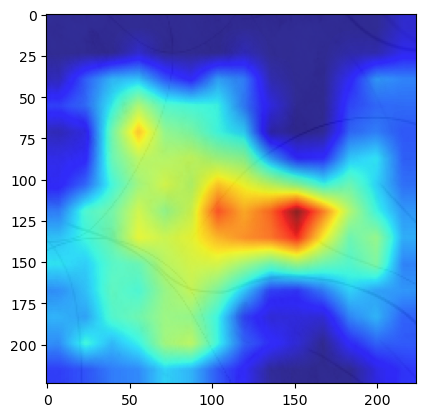

In [53]:
def save_and_display_gradcam(img_array, heatmap, alpha=0.4):
    # Load the original image
    
    img = (img_array[0] + 1)/2

    # Rescale heatmap to a range 0-255
    #heatmap = np.uint8(255 * heatmap)
    plt.imshow(img,alpha=1.0)
    plt.imshow(cv2.resize(heatmap,(image_size,image_size)),cmap='jet',alpha=0.8)
    plt.show()

# Display Grad CAM
save_and_display_gradcam(img_array, heatmap)